# ECG PROJECT

by Erica Brisigotti (2097202), Ekaterina Chueva (2072050), Sofia Pacheco Garcia (2070771), Nadillia Sahputra (2070770)

In [81]:
import os
import wfdb
import wfdb.processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import fftpack, stats, signal
import pywt
from scipy import stats
import time
import copy

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
import joblib
from joblib import Parallel, delayed


# firstly, I set
# - a saving option
FILE_SAVE = False
# - a second saving option for redudant yet maybe worth doing for small datasets
EXTRA_SAVE_FOR_SMALL_DATA = False
# - an option to show the structure of the datasets anayzed (both in general and for the specific chosen example)
SHOW_STRUCTURE = False
# - the color of the records from a healthier patient in plots
ch = 'forestgreen'
# - the color of the annotations from a healthier patient in plots
cha = 'navy'
# - an additional color for a healthier patient in plots
che = 'deepskyblue'
# - the color of the records from a more sick patient in plots
cs = 'darkorange'
# -  the color of the annotaitons from a more sick patient in plots
csa = 'red' 
# - an additional color for a more sick patient in plots
cse = 'maroon'
# - an option for the classification algorithm (between xgboost and ??)
ML_ALGORITHM = 'xgboost'

# 1A. Data Preprocessing Example

To select the parameters for the preprocessing part, we select two random datasets, one from the first half and one from second half of the set of patients. Such a split is justified by the knowledge that the second half of patients is generally more sick (since it was purposefully introduced to insert more sick patients).

To reach such a goal, we upload the two WFDB records using the <code>rdrecord</code> function. They are uploaded as <code>wfdb.Record</code> objects, with many different attributes. Of such attributes, we are interested in the sampling frequency <code>.fs</code> and in the time series, which is stored under as <code>.p_signal</code>.

Similarly, the annotations for the two patients are uploaded using the <code>rdann</code> function, that retuns <code>wfdb.Record</code> objects with many attributes. Of such attributes, we are interested in the annotation indexes (saved as <code>.sample</code> ) and symbols (under <code>.symbol</code>).

In [31]:
t_start_all = time.time()

address_1 = "I01"
address_2 = "I07"
record_1 = wfdb.rdrecord('input_files/'+address_1)
record_2 = wfdb.rdrecord('input_files/'+address_2)
ann_1 = wfdb.rdann('input_files/'+address_1,"atr")
ann_2 = wfdb.rdann('input_files/'+address_2,"atr")

if SHOW_STRUCTURE:
    print('the structure of the wfdb.Record object is:')
    display(record_1.__dict__)
    print(len(ann_1.sample), 'is the number of annotations in record',address_1)
    print(set(ann_1.symbol), 'are the unique annotations in record',address_1)
    print(len(ann_2.sample), 'is the number of annotations in record',address_2)
    print(set(ann_2.symbol), 'are the unique features in record',address_2)
    print('\n all the possible annotations are: ')
    wfdb.show_ann_labels()
    print('\nabout patient '+address_1)
    with open("input_files/"+address_1+".hea", 'r') as file:
        t = file.read().replace('#',"")
        hea = t.split('\n')
        print('\n',hea[3],": the first two data are info about the age and gender")
        temp = hea[3].split(" ")
        print(temp[1]," is the age of the patient and ",temp[2],"is the gender of the patient")
        print(hea[4],": are the meds the patient is on")
        print(hea[5],": are the notes for the patient")
    print('\nabout patient '+address_2)
    with open("input_files/"+address_1+".hea", 'r') as file:
        t = file.read().replace('#',"")
        hea = t.split('\n')
        print('\n',hea[3],": the first two data are info about the age and gender")
        temp = hea[3].split(" ")
        print(temp[1]," is the age of the patient and ",temp[2],"is the gender of the patient")
        print(hea[4],": are the meds the patient is on")
        print(hea[5],": are the notes for the patient")

In [32]:
s0_1 = record_1.p_signal[:,0]
s1_1 = record_1.p_signal[:,10]
a_1 = ann_1.sample
s0_2 = record_2.p_signal[:,0]
s1_2 = record_2.p_signal[:,10]
a_2 = ann_2.sample
freq = record_1.fs

We plot the records and annotations in both leads for both patients:

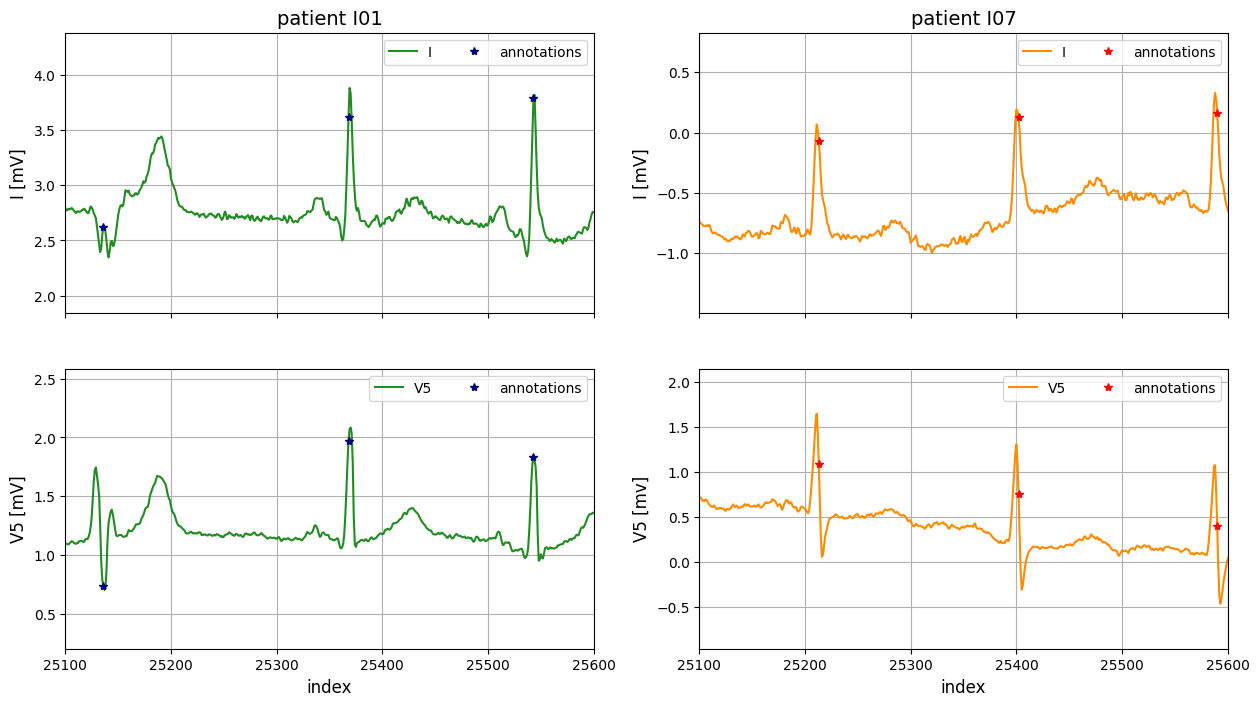

In [33]:
fig1, ax1 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

ax1[0][0].plot(s0_1, '-', label='I', color=ch)
ax1[0][0].plot(a_1, s0_1[a_1], '*', label = 'annotations', color=cha)
ax1[0][0].set_xlim(start_point, end_point)
ax1[0][0].set_ylim(min(s0_1[start_point:end_point])-0.5, max(s0_1[start_point:end_point])+0.5)
ax1[0][0].set_ylabel('I [mV]', fontsize=12)
ax1[0][0].set_title('patient '+address_1, fontsize=14)
ax1[0][0].legend(ncol=2, fontsize=10)
ax1[0][0].grid()

ax1[0][1].plot(s0_2, '-', label='I', color=cs)
ax1[0][1].plot(a_2, s0_2[a_2], '*', label='annotations', color=csa)
ax1[0][1].set_ylim(min(s0_2[start_point:end_point])-0.5, max(s0_2[start_point:end_point])+0.5)
ax1[0][1].set_ylabel('I [mV]', fontsize=12)
ax1[0][1].set_title('patient '+address_2, fontsize=14)
ax1[0][1].legend(ncol=2, fontsize =10)
ax1[0][1].grid()

ax1[1][0].plot(s1_1, '-', label='V5', color=ch)
ax1[1][0].plot(a_1, s1_1[a_1], '*', label = 'annotations', color=cha)
ax1[1][0].set_ylim(min(s1_1[start_point:end_point])-0.5, max(s1_1[start_point:end_point])+0.5)
ax1[1][0].set_xlabel('index', fontsize=12)
ax1[1][0].set_ylabel('V5 [mV]', fontsize=12)
ax1[1][0].legend(ncol=2, fontsize=10)
ax1[1][0].grid()

ax1[1][1].plot(s1_2, '-', label='V5', color=cs)
ax1[1][1].plot(a_2, s1_2[a_2], '*', label='annotations', color=csa)
ax1[1][1].set_ylim(min(s1_2[start_point:end_point])-0.5, max(s1_2[start_point:end_point])+0.5)
ax1[1][1].set_xlabel('index', fontsize=12)
ax1[1][1].set_ylabel('V5 [mv]', fontsize=12)
ax1[1][1].legend(ncol=2, fontsize=10)
ax1[1][1].grid()

plt.show()

We see that, in general, the MLII signal is more aligned with annotations and has a higher signal-noise ratio. For this reason, it will be used to draw conclusions in the following chapters.

We implement filtering since the signal is visibly noisy and includes a baseline wonder. We filter with both fast Fourier transform and Wavelet transform tecniques, which are applied serially.

First of all, for the **Fast Fourier Transform**, we want to display and analyze the frequency spectra (which is extracted by the <code>power_fft</code> function).

In [34]:
def power_fft(vect, timestamp):
    vect_fft = fftpack.fft(vect)
    vect_power = np.abs(vect_fft)
    vect_all_freq = fftpack.fftfreq(vect.size, d = timestep)
    return vect_fft, vect_power, vect_all_freq

In [35]:
timestep = 1/freq
norm_fft_1, norm_power_1, norm_all_freq_1 = power_fft(s0_1, timestep)
norm_fft_2, norm_power_2, norm_all_freq_2 = power_fft(s0_2, timestep)

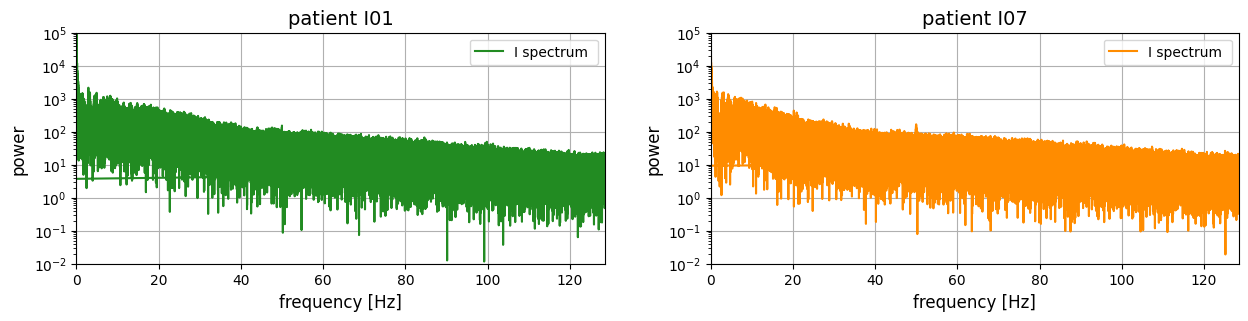

In [36]:
fig2, ax2 = plt.subplots(1, 2, figsize = (15, 3), sharex = True)

ax2[0].plot(norm_all_freq_1, norm_power_1, '-', label='I spectrum ', color=ch)
ax2[0].set_xlim(0,max(norm_all_freq_1))
ax2[0].set_ylim(10**(-2), 10**5)
ax2[0].set_yscale('log')
ax2[0].set_xlabel('frequency [Hz]', fontsize=12)
ax2[0].set_ylabel('power', fontsize=12)
ax2[0].set_title('patient '+address_1, fontsize=14)
ax2[0].legend(loc='upper right', ncol=2, fontsize=10)
ax2[0].grid()

ax2[1].plot(norm_all_freq_2, norm_power_2, '-', label='I spectrum ', color=cs)
ax2[1].set_ylim(10**(-2),10**5)
ax2[1].set_yscale('log')
ax2[1].set_xlabel('frequency [Hz]', fontsize=12)
ax2[1].set_ylabel('power', fontsize=12)
ax2[1].set_title('patient '+address_2, fontsize=14)
ax2[1].legend(loc='upper right', ncol=2, fontsize=10)
ax2[1].grid()

plt.show()

We notice a peak at around 60 Hz, which is due to the power supply of the recording device and must be discarded. We also see high values of the spectrum for low frequency, which should be discarded as well.

Therefore, we decide to implement a band-pass filter: the precise cut frequencies are chosen in the interval $[0.1-55]$ Hz.

In [37]:
down_freq_lim = np.array([0.1, 1, 2])
up_freq_lim = np.array([25, 35, 45])

We notice a peak at around 60 Hz, which is due to the power supply of the recording device and must be discarded. We also see high values of the spectrum for low frequency, which should be discarded as well.

Therefore, we decide to implement a band-pass filter: the precise cut frequencies are chosen in the interval $[0.1-50]$ Hz.

The cut frequency are chosen visually based on the results of their filtering (which is done by the <code>filtered_power</code>) that are shown in the plot below.


In [38]:
def filtered_power(vect_fft, vect_all_freq, down_freq_lim, up_freq_lim):
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[np.abs(vect_all_freq) >= up_freq_lim] = 0
    vect_filtered_fft[np.abs(vect_all_freq) <= down_freq_lim] = 0
    vect_filtered = (fftpack.ifft(vect_filtered_fft)).real
    return vect_filtered

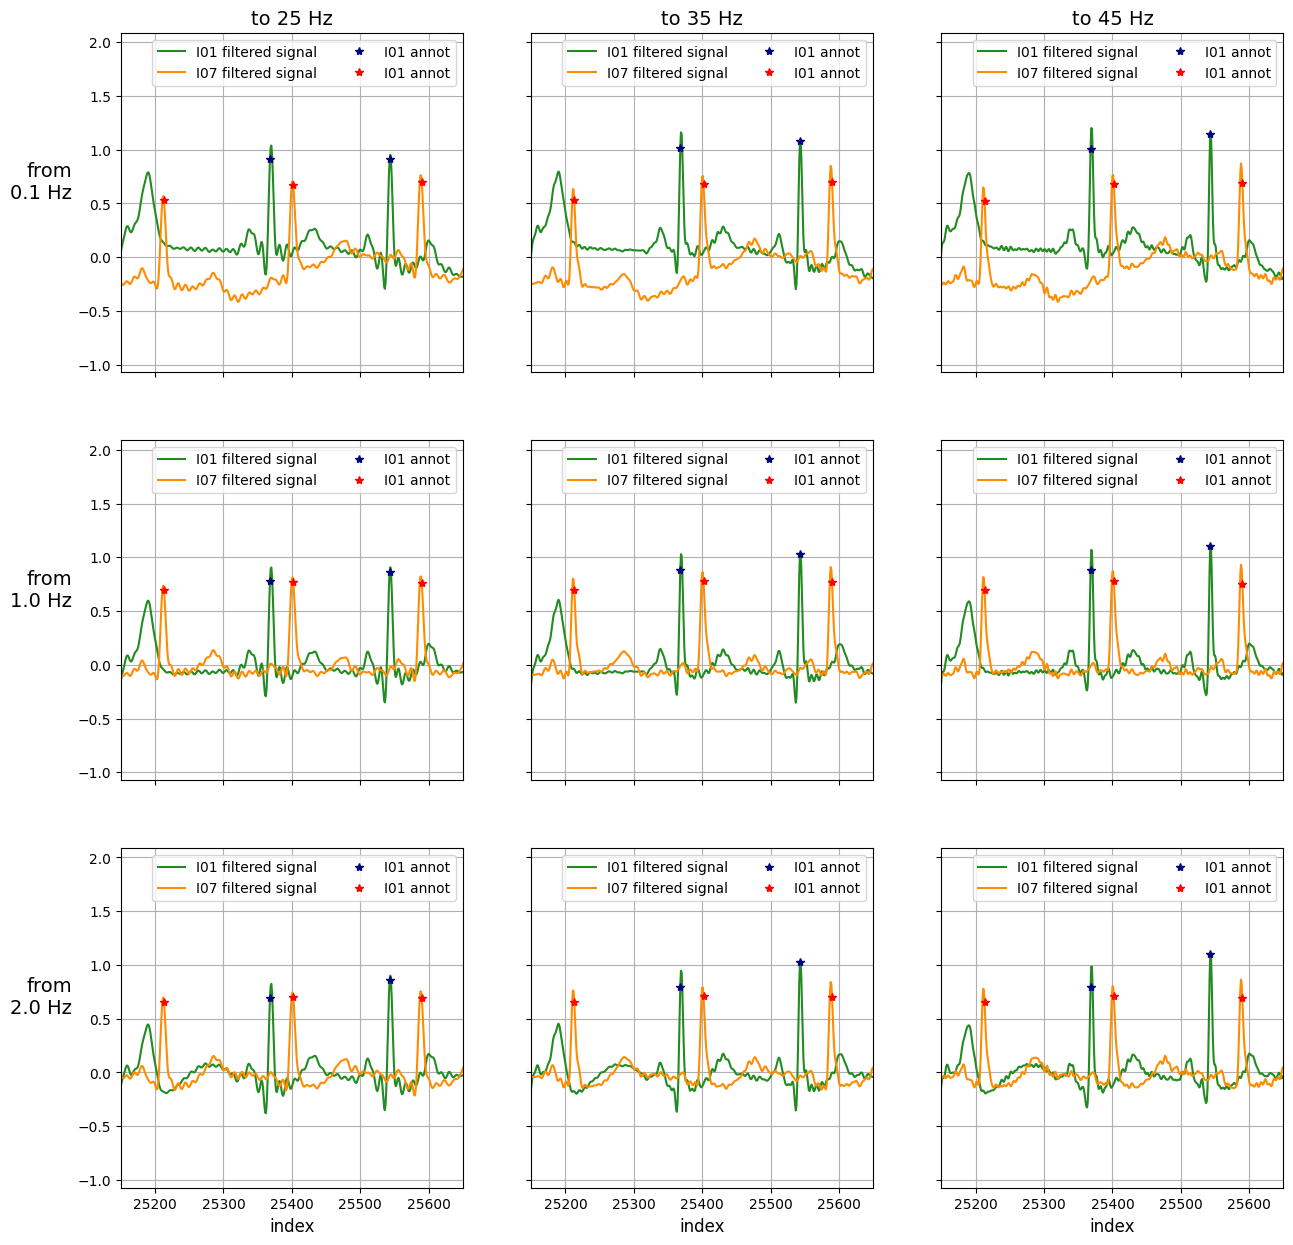

In [39]:
fig3, ax3 = plt.subplots(len(down_freq_lim), len(up_freq_lim), figsize = (15, 15), sharex=True, sharey=True)

start_point = 25150
end_point = start_point+500

for i in range(len(down_freq_lim)):
    for j in range(len(up_freq_lim)):
        norm_filtered_1 = filtered_power(norm_fft_1, norm_all_freq_1, down_freq_lim[i], up_freq_lim[j])
        x_1 = np.arange(0, len(norm_filtered_1), 1)
        norm_filtered_2 = filtered_power(norm_fft_2, norm_all_freq_2, down_freq_lim[i], up_freq_lim[j])
        temp = np.concatenate([norm_filtered_1[start_point:end_point],norm_filtered_2[start_point:end_point]])
        ax3[i][j].plot(norm_filtered_1, '-', label=address_1+' filtered signal', color=ch)
        ax3[i][j].plot(norm_filtered_2, '-', label=address_2+' filtered signal', color=cs)
        ax3[i][j].plot(a_1, norm_filtered_1[a_1], '*', label=address_1+' annot', color=cha)
        ax3[i][j].plot(a_2, norm_filtered_2[a_2], '*', label=address_1+' annot', color=csa)
        ax3[i][j].grid()
        ax3[i][j].legend(fontsize=10, ncol=2)
        ax3[i][j].set_xlim(start_point, end_point)
        ax3[i][j].set_ylim(1.3*(min(temp)-0.5), 1.3*(max(temp)+0.5))
        if i==0:
            ax3[i][j].set_title("to "+str(up_freq_lim[j])+" Hz", fontsize=14)
        if j==0:
            ax3[i][j].set_ylabel('from\n'+str(down_freq_lim[i])+" Hz", fontsize=14, rotation=0, ha="right")
        if i==(len(up_freq_lim)-1):
            ax3[i][j].set_xlabel('index', fontsize=12)

From the plots we can see that:
- for small upper limits (e.g. 10 Hz), the filtered signal is too smooth and there is loss of important information
- for intermediate upper limits (e.g. 30 Hz), the filtered signal is still quite noisy
- for nigher upper limits (e.g. 50 Hz), the filtered signal is smoother without major loss of information
- there is no visible variation coming from the different lower limits

Therefore, we decide to set:
- the lower cut frequency as the lowest value, 0.1 Hz
- the upper cut frequency as the highest value available, 50 Hz

In [40]:
down_freq_lim = 0.1
up_freq_lim = 50

We can now show the FFT filtered leads for both patients

In [41]:
norm_filtered_1 = filtered_power(norm_fft_1, norm_all_freq_1, down_freq_lim, up_freq_lim)
norm_fft_s0_1, norm_power_s0_1, norm_all_freq_s0_1 = power_fft(s0_1, timestep)
norm_fft_s0_2, norm_power_s0_2, norm_all_freq_s0_2 = power_fft(s0_2, timestep)
norm_fft_s1_1, norm_power_s1_1, norm_all_freq_s1_1 = power_fft(s1_1, timestep)
norm_fft_s1_2, norm_power_s1_2, norm_all_freq_s1_2 = power_fft(s1_2, timestep)
f_s0_1 = filtered_power(norm_fft_s0_1, norm_all_freq_s0_1, down_freq_lim, up_freq_lim)
f_s0_2 = filtered_power(norm_fft_s0_2, norm_all_freq_s0_2, down_freq_lim, up_freq_lim)
f_s1_1 = filtered_power(norm_fft_s1_1, norm_all_freq_s1_1, down_freq_lim, up_freq_lim)
f_s1_2 = filtered_power(norm_fft_s1_2, norm_all_freq_s1_2, down_freq_lim, up_freq_lim)

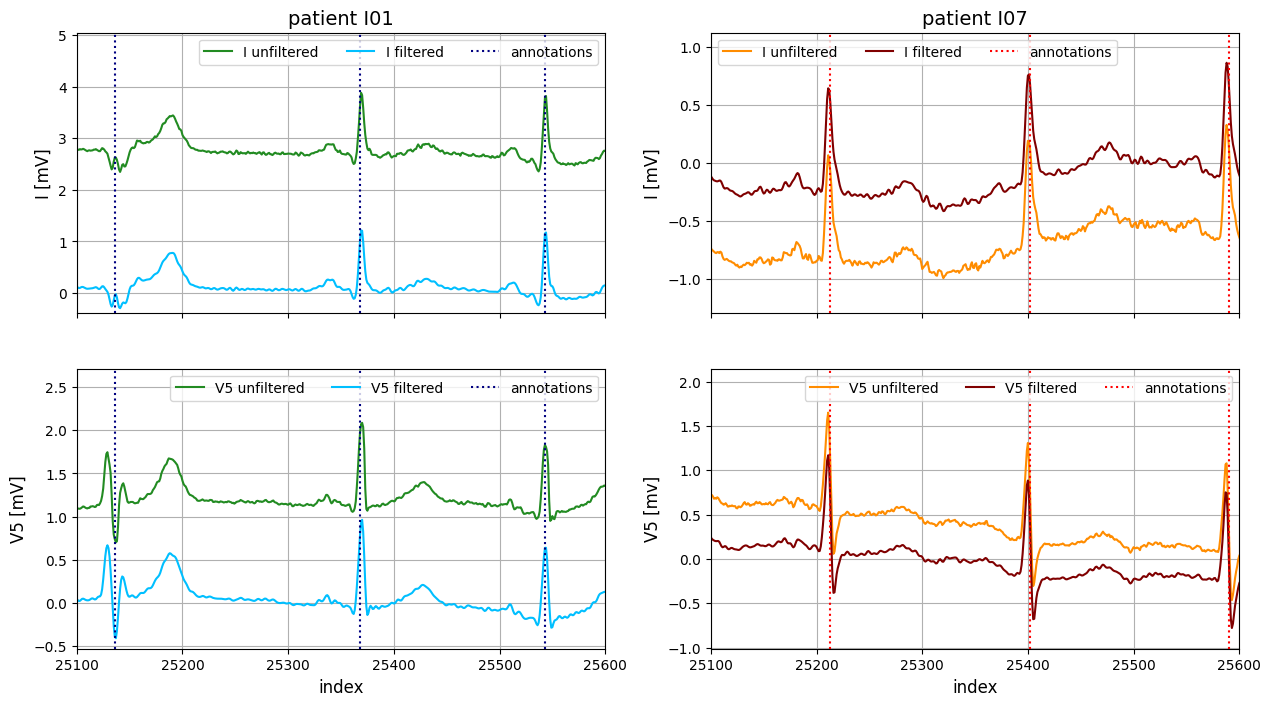

In [42]:
fig4, ax4 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

ax4[0][0].plot(s0_1, '-', label='I unfiltered', color=ch)
ax4[0][0].plot(f_s0_1, '-', label='I filtered', color=che)
ax4[0][0].set_xlim(start_point, end_point)
temp = np.concatenate([s0_1[start_point:end_point], f_s0_1[start_point:end_point]])
ax4[0][0].vlines(a_1, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label = 'annotations', color=cha)
ax4[0][0].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[0][0].set_ylabel('I [mV]', fontsize=12)
ax4[0][0].set_title('patient '+address_1, fontsize=14)
ax4[0][0].legend(ncol=3, fontsize=10)
ax4[0][0].grid()

ax4[0][1].plot(s0_2, '-', label='I unfiltered', color=cs)
ax4[0][1].plot(f_s0_2, '-', label='I filtered', color=cse)
temp = np.concatenate([s0_2[start_point:end_point], f_s0_2[start_point:end_point]])
ax4[0][1].vlines(a_2, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label='annotations', color=csa)
ax4[0][1].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[0][1].set_ylabel('I [mV]', fontsize=12)
ax4[0][1].set_title('patient '+address_2, fontsize=14)
ax4[0][1].legend(ncol=3, fontsize=10)
ax4[0][1].grid()

ax4[1][0].plot(s1_1, '-', label='V5 unfiltered', color=ch)
ax4[1][0].plot(f_s1_1, '-', label='V5 filtered', color=che)
temp = np.concatenate([s1_1[start_point:end_point], f_s1_1[start_point:end_point]])
ax4[1][0].vlines(a_1, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label='annotations', color=cha)
ax4[1][0].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[1][0].set_xlabel('index', fontsize=12)
ax4[1][0].set_ylabel('V5 [mV]', fontsize=12)
ax4[1][0].legend(ncol=3, fontsize=10)
ax4[1][0].grid()

ax4[1][1].plot(s1_2, '-', label='V5 unfiltered', color=cs)
ax4[1][1].plot(f_s1_2, '-', label='V5 filtered', color=cse)
temp = np.concatenate([s1_2[start_point:end_point], f_s1_2[start_point:end_point]])
ax4[1][1].vlines(a_2, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label='annotations', color=csa)
ax4[1][1].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[1][1].set_xlabel('index', fontsize=12)
ax4[1][1].set_ylabel('V5 [mv]', fontsize=12)
ax4[1][1].legend(ncol=3, fontsize=10)
ax4[1][1].grid()

plt.show()

We filter the results shown above with **disctere wavelet transform**. We use a sym4 wavelet and a maximum possible decomposition level.

In [43]:
def wavelet(data): 
        w = pywt.Wavelet('sym4')
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        threshold = 0.04 # Threshold for filtering
        coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        datarec = pywt.waverec(coeffs, 'sym4')
        return datarec

We can summarize both of the filtering steps into a single function. In the function, we also include the <code>stats.zscore</code> function that do normalization so that the mean value is 0 and standard deviation is 1. 

In [44]:
def filtering(s,freq,down_freq_lim,up_freq_lim):
    def power_fft(vect, timestamp):
        vect_fft = fftpack.fft(vect)
        vect_power = np.abs(vect_fft)
        vect_all_freq = fftpack.fftfreq(vect.size, d = timestep)
        return vect_fft, vect_power, vect_all_freq
    timestep = 1/freq
    norm_fft, norm_power, norm_all_freq = power_fft(s, timestep)
    def filtered_power(vect_fft, vect_all_freq, down_freq_lim, up_freq_lim):
        vect_filtered_fft = vect_fft.copy()
        vect_filtered_fft[np.abs(vect_all_freq) >= up_freq_lim] = 0
        vect_filtered_fft[np.abs(vect_all_freq) <= down_freq_lim] = 0
        vect_filtered = (fftpack.ifft(vect_filtered_fft)).real
        return vect_filtered
    fft_filtered = filtered_power(norm_fft, norm_all_freq, down_freq_lim, up_freq_lim)
    def wavelet(data): 
        w = pywt.Wavelet('sym4')
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        threshold = 0.04 # Threshold for filtering
        coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        datarec = pywt.waverec(coeffs, 'sym4')
        return datarec
    norm_filtered = stats.zscore(wavelet(fft_filtered))
    return norm_filtered

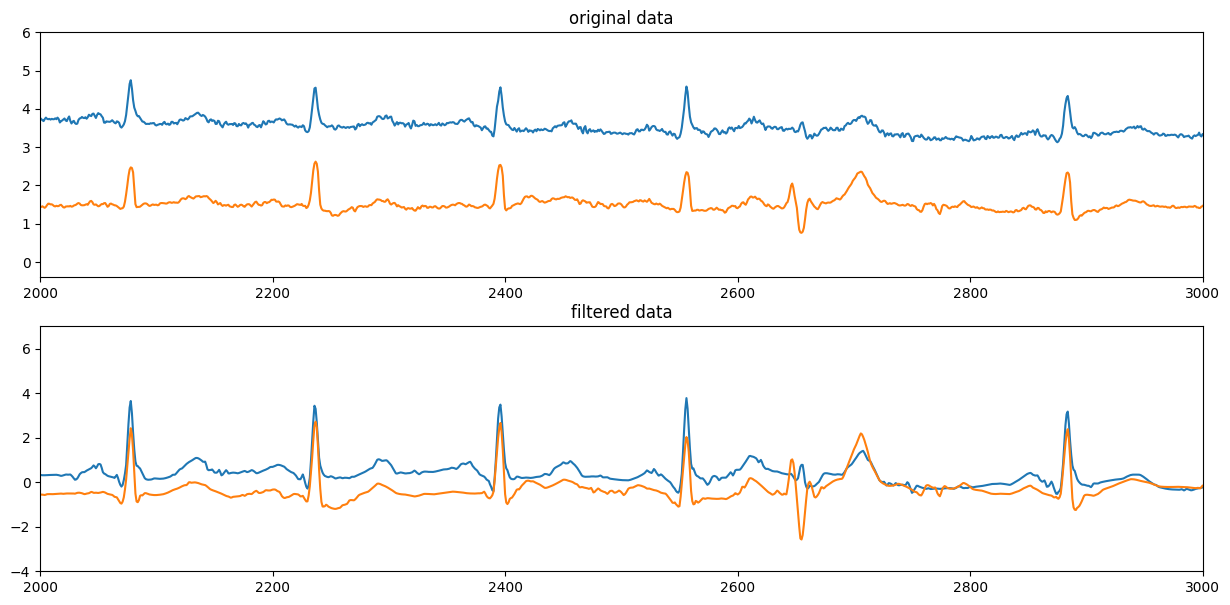

mean of data 1: 0.0
std of data 1: 1.0
mean of data 2: -0.0
std of data 2: 1.0


In [45]:
# plot of filtered data after both filtering by basically copying & modifying fig4
# the original plot was the code below but displays just one patient and isn't in style with the previous one

fig5, ax5 = plt.subplots(2,1,figsize = (15, 7))
ax5[0].plot(s0_1) # asymmetric yet simple normalization
ax5[0].plot(s1_1)
ax5[0].set_xlim(2000,3000)
ax5[0].set_ylim(-0.4,6)
ax5[0].set_title("original data")
ax5[1].plot(filtering(s0_1,freq,down_freq_lim,up_freq_lim))
ax5[1].plot(filtering(s1_1,freq,down_freq_lim,up_freq_lim))
ax5[1].set_xlim(2000,3000)
ax5[1].set_ylim(-4,7)
ax5[1].set_title("filtered data")
plt.show()
print("mean of data 1:",round(np.mean(filtering(s0_1,freq,down_freq_lim,up_freq_lim)),3))
print("std of data 1:",round(np.std(filtering(s0_1,freq,down_freq_lim,up_freq_lim)),3))
print("mean of data 2:",round(np.mean(filtering(s1_1,freq,down_freq_lim,up_freq_lim)),3))
print("std of data 2:",round(np.std(filtering(s1_1,freq,down_freq_lim,up_freq_lim)),3))

Lastly, to be safe we want to **eliminate the baseline wonder** of the signal to align the isoelectric line. We do this by substracting a low order polynomial function from the signal. </span> Just like before, we use the <code>stats.zscore</code> function to standardize the output. 

In [46]:
def isoelectric_signal(s0, freq):    
    y1=filtering(s0,freq,down_freq_lim,up_freq_lim)
    x=range(len(y1))

    coefs_filt_1=np.polyfit(x, y1, 8, rcond=None, full=False, w=None, cov=False)

    isoelectric_signal_1=y1-np.polyval(coefs_filt_1, x)
    isoelectric_signal_1 = stats.zscore(isoelectric_signal_1)

    return (isoelectric_signal_1)

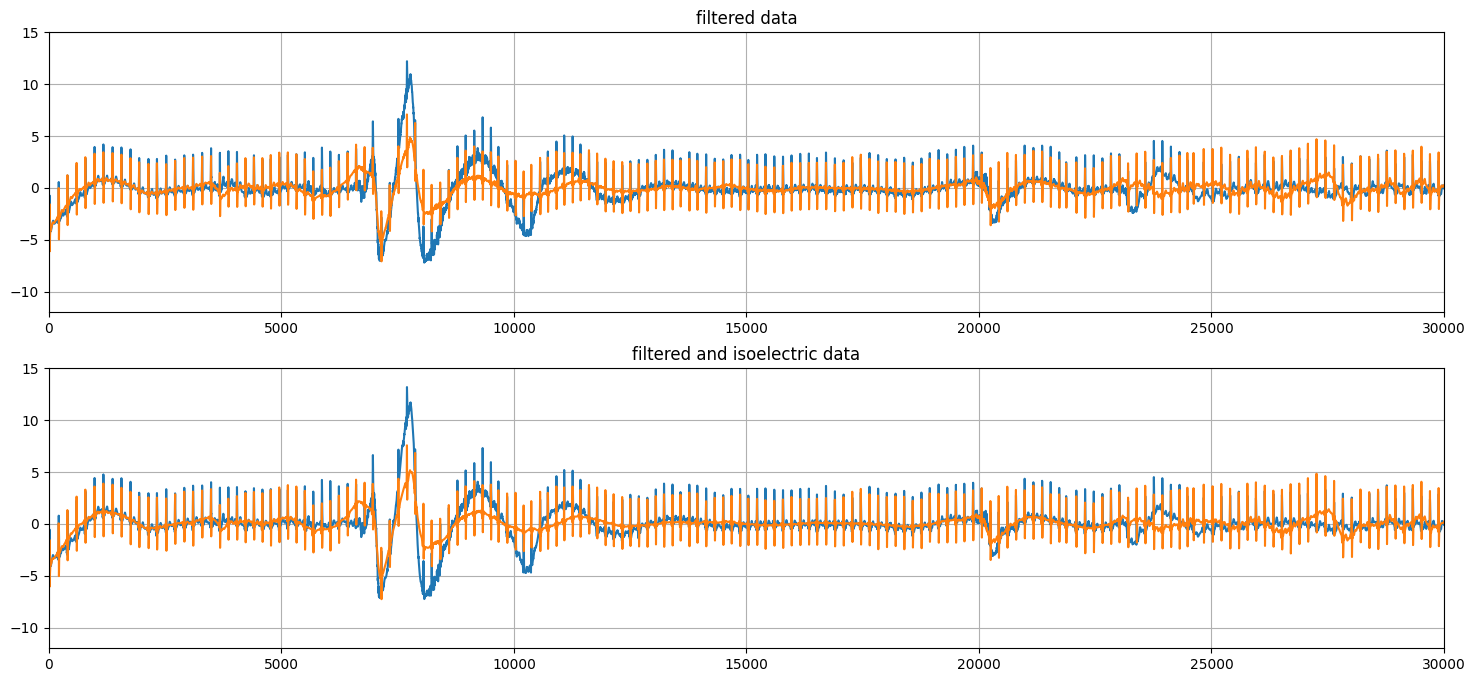

In [47]:
# plot of filtered data after eliminating baselinewonder by basically copying & modifying fig4 and/or fig5
# the original plot was the code below but displays just one lead and one patient and isn't in style with the previous one

s0_f = filtering(s0_2,freq,down_freq_lim,up_freq_lim)
s1_f = filtering(s1_2,freq,down_freq_lim,up_freq_lim)

fig6, ax6 = plt.subplots(2,1,figsize = (18, 8))
ax6[0].plot(s0_f)
ax6[0].plot(s1_f)
ax6[0].set_xlim(0,30000)
ax6[0].set_ylim(-12,15)
ax6[0].grid(True)
ax6[0].set_title("filtered data")

ax6[1].plot(isoelectric_signal(s0_f,freq))
ax6[1].plot(isoelectric_signal(s1_f,freq))
ax6[1].set_xlim(0,30000)
ax6[1].set_ylim(-12,15)
ax6[1].grid(True)
ax6[1].set_title("filtered and isoelectric data")
plt.show()

# 1B) Data Preprocessing on the entire dataset

First of all, we store the additional information that we're able to interpret in a dataframe.

In [48]:
r  = np.genfromtxt("input_files/RECORDS", dtype='str')
records = list(range(1,(len(r)+1)))

if FILE_SAVE:
#     records = "L0"+records
    t1 = time.time()
    age = [None]*len(records)
    gender = [None]*len(records)
    notes = [None]*len(records)
    for i,path in enumerate(records):
        path = str(path).zfill(2)
        with open("input_files/I"+path+".hea", 'r') as file:
            t = file.read().replace('#',"")
            hea = t.split('\n')
            temp = hea[3].split(" ")
            age[i] = int(temp[1])
            if (int(temp[1])<0):
                age[i] = float("NaN")
            gender[i] = temp[2]
            notes[i] = hea[5]
    metadata = pd.DataFrame({"patient": records, "age": age, "gender": gender, "notes": notes})
    outfn = 'output_files/'+"metadata"+'.csv'
    metadata.to_csv(outfn, index=False)
    t2 = time.time()
    print('the metadata saving took',t2-t1,'seconds')
else:
    metadata = pd.read_csv('output_files/metadata.csv')
    
metadata.head()

,patient,age,gender,notes
0,1,16,306,I01.dat 16 306 16 0 467 2125 0 AVL
1,2,16,306,I02.dat 16 306 16 0 362 -5961 0 AVL
2,3,16,1041,I03.dat 16 1041 16 0 3284 28978 0 AVL
3,4,16,1041,I04.dat 16 1041 16 0 -5070 -5972 0 AVL
4,5,16,1041,I05.dat 16 1041 16 0 -1834 16706 0 AVL


We avoid saving the unfiltered signal in a .csv format, but the option is there if needed: in such a case, the data relative to each patient is saved in a dataframe, in which each columns correspond to one lead.

In [49]:
records = list(range(1,(len(r)+1)))

if EXTRA_SAVE_FOR_SMALL_DATA:
    t1 = time.time()
    for path in records:
        # Load the record
        path = str(path).zfill(2)
        record = wfdb.rdrecord("input_files/I"+path)
        signal = record.sig_name
        df = pd.DataFrame()
        for i in range(0,len(signal)):
            df[signal[i]] = record.p_signal[:, i]

        # Save the DataFrame to a CSV file
        outfn = 'output_files/'+'data'+path+'.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the metadata saving took',t2-t1,'seconds')

We then save the annotations in .cvs format by creating, for each patient, a dataframe with a index and a symbol column:

In [50]:
# save annotations in csv
if FILE_SAVE:
    t1 = time.time()
    for path in records:
        path = str(path).zfill(2)
        # Read the annotation file for record 100
        annotation = wfdb.rdann("input_files/I"+path, 'atr')

        # Create a pandas DataFrame with the annotation data
        df = pd.DataFrame({'index': annotation.sample.tolist(), 'symbol': annotation.symbol})

        # Save the DataFrame to a CSV file
        outfn = 'output_files/'+'data'+path+'_ann.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the annotation saving took',t2-t1,'seconds')

Finally, we save the filtered signal in a .csv format: the data relative to each patient is saved in a dataframe, in which each columns correspond to one lead.

In [51]:
if FILE_SAVE:
    t1 = time.time()
    for path in records:
        path = str(path).zfill(2)
        # Load the record
        record = wfdb.rdrecord("input_files/I"+path)
        signal = record.sig_name
        df = pd.DataFrame()
        for i in range(0,len(signal)):
            df[signal[i]] = isoelectric_signal(record.p_signal[:, i],freq)

        # Save the DataFrame to a CSV file
        outfn = "output_files/"+"data"+path+'_filtered.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the filtered data saving took',t2-t1,'seconds')

# 2) Correction of Annotations

#### 2.1.1. Peak detection algorithm

Quadratic mean parabola-fit error $\varepsilon (i)$

$\varepsilon(i)=\frac{1}{2 w+1} \sum_{j=i-w}^{i+w}\left(y(j)-y^{\prime}(j)\right)^2$

Where: 

- $\varepsilon (i)$ is a sequence for $i \in\{w, w+1, w+2, \cdots, N-w-1\}$

- $\omega$ is a positive number such that $2\omega + 1<N$

- $y(j)$ is a sequence, fragment of $y(n)$, centered at index: $j \in\{i-w, i-w+1, i-w+2, \cdots, i, i+1, i+2, \cdots, i+w-1, i+w\}$
    
    m = length of both $y(j)$ and $y\prime(j)$ = $2w+1$
    
    .
    
- The sequence $y\prime (j)$ is defined by a parabola with vertex at index i, that best fits the ECG signal fragment $y(j)$:

    $y^{\prime}(j)=a(i-j)^2+v$
    
__Goal:__ Calculate the values for $a$ and $v$  that make $y^{\prime}(j)$ to best fit $y(j)$

__Method:__ Linear regression (identifying $x=(i-j)^2$ so that $y^{\prime}(j)=ax+v$ )

The vertex of the parabola will be located at $(i,v)$.

The following formulas give the two needed parameters for the fit:

$a=\frac{m \sum_{j=l_1}^{l_2} x(j) y(j)-\sum_{j=l_1}^{l_2} x(j) \sum_{j=l_1}^{l_2} y(j)}{m \sum_{j=l_1}^{l_2} x^2(j)-\left(\sum_{j=l_1}^{l_2} x(j)\right)^2}$

$v=\frac{\sum_{j=l_1}^{l_2} x^2(j) \sum_{j=l_1}^{l_2} y(j)-\sum_{j=l_1}^{l_2} x(j) y(j) \sum_{j=l_1}^{l_2} x(j)}{m \sum_{j=l_1}^{l_2} x^2(j)-\left(\sum_{j=l_1}^{l_2} x(j)\right)^2}$

with $m$ the window size and $l_1=i-w$, $l_2=i+w$ limits of the sums.

In this way, a parabola $y^{\prime}$ that can adjust to the values in the time window (which will go through the entire signal) is generated. 

_When  there is a peak in the processed signal $y(i)$, the vertex of the parabola will coincide with the maximum or minimum point of the wave._

__Peak detection:__ comprise signal $y(i)$ using the error signal and compare signal $y(j)$ to the parabola $y^{\prime}$. Lower values of $\varepsilon(i)$ show the position of a max or min. If $y(j)$ is very similar to a straight line, the value $\varepsilon(i)$ will be very low causing false positives; this can be avoided by using the $a$ coefficient of the parabola to differenciate a straight line ($a \rightarrow 0$) from a wave.


__How to proceed:__ 
- 1: Obtain error signal $\varepsilon(i)$
- 2: Store the $y(n)$ values when $\varepsilon(i)$ is close to 0 and higher than the defined limit (to avoid false possitives in straight lines).
- 3: Those values will be the R points. (Also possible to obtain the average value of the isoelectric line).

        Window size for R peak detection is defined by the average duration of the QRS complex (from 70 to 100 ms). Taking he approx width of R peak and $f_s$ being the freq of signal sampling: 

            nº samples of half of the window = w = 0.030 x f_s

In [52]:
def yfit(yn, fs=freq, peak_width=0.032):
    
    w = int(peak_width*fs) #number of samples in half of the window
    m = 2*w+1 #number of samples in a window
    
    #i is a sequence that goes from w(half size of a window) to N-w being N the total number of data
    i = np.arange(w,len(yn)-w)
    #j is a matrix, each row is the array of the indexes of a window
    j = np.zeros((len(i),m-1))
    for k in range(len(i)):
        j[k] = np.arange(k,k+m-1)

    #x is the change of variable such that instead of a 2nd order fit, we can perform a linear fit
    x = (j[0]-i[0])**2
    
    #yj is a matrix, each row is an array with the signal (data) values for each of the indexes of a window
    yj = yn[j.reshape(j.shape[0]*j.shape[1])].values.reshape(j.shape[0], j.shape[1])

    #a and v are the parameters of the fit such that yj_fit=ax+v. They both are arrays containing the parameters for each i.
    a = ((m*np.sum((x*yj), axis=1))-(np.sum(x)*np.sum(yj, axis=1)))/(m*np.sum(x**2)-(np.sum(x))**2)
    v = ((np.sum(x**2)*np.sum(yj, axis=1))-(np.sum((x*yj), axis=1)*np.sum(x)))/(m*np.sum(x**2)-(np.sum(x))**2)
    
    #yj_fit=ax+v is a matrix that contains in each row the fitted signal for each window 
    yj_fit = (np.tile(a.reshape(len(a)), (m-1,1)).T)*x + (np.tile(v.reshape(len(v)), (m-1,1)).T)

    #eps_i is the Quadratic mean parabola-fit error  𝜀(𝑖) for each i
    eps_i = (1/(2*w+1))*np.sum(((yj-yj_fit)**2), axis=1)
    
    return(eps_i, a, v)

In [53]:
# def align(r, ann_idx, ann_symb, level):
#     # code that returns a one-to-one correspondance between:
#     # - the vector of r-peaks r
#     # - the annotations indexes ann_idx
#     # while estabilishing this correspondance, the third input (ann_symbol) is altered identically to ann_idx
#     # since the desired outcome of the code is to find the ann_symb corresponding to r
#     # the fourth input (level) is a treshold to be set based on the RR distance

#     # I make deep copies that I can safely modify during the loop without loss of data
#     rpeaks = copy.copy(r)
#     ann_indexes = copy.copy(ann_idx) 
#     ann_symbols = copy.copy(ann_symb)
#     # and I set a threshold for the minimum distance for acceptance of the correspondance
#     #level = 30
#     # lastly, I initialize the vectors in which I'm going to save the results
#     r_aligned = list()
#     ann_aligned = list()
#     ann_symbols_aligned = list()
#     sort_distance = np.zeros(100)
    

# #     for i in range(len(ann_idx)-1):
#     while (len(sort_distance)>1) & (len(ann_indexes)>1):
#         # I get the current element to examine
# #         print(len(ann_indexes),len(sort_distance))
        
#         ann_index = ann_indexes[0]
# #         print(len(ann_indexes),len(sort_distance))
#         # calculate the distance of the many (remaining) rpeaks from it
#         distance = np.abs(rpeaks - ann_index)
#         # and sort such distances to find the minimum distance and the index (of rpeaks) corresponding to it
#         sort_distance = pd.DataFrame({'distance': distance}).sort_values(by=['distance'])
#         # we set the corresponding index to be the 
#         min_distance = sort_distance.distance.values[0]
#         # If the minimum distance is appropriate
#         if min_distance<level:
#             # I get the index corresponding to the minimum distance
#             min_distance_idx = sort_distance.index.values[0]
#             # I save the rpeak corresponding to minimum distance
#             r_aligned.append( rpeaks[ min_distance_idx ] )
#             # And the annotation index
#             ann_aligned.append( ann_indexes[0] )
#             # and save the corresponding annotation
#             ann_symbols_aligned.append( ann_symbols[0] )
#             # and remove the annotations (both index and symbol) and rpeak corresponding to this configuration,
#             # to avoid repetitions and grant a one-to-one correspondance
#             rpeaks = np.delete(rpeaks, min_distance_idx)
#             ann_indexes = np.delete(ann_indexes, 0 )
#             ann_symbols = np.delete(ann_symbols, 0 )
#         # otherwise (if the closest value is too far away to be considered close)
#         else:
#             # I forget about the data corresponding to this annotation since there's no correspondance in the rpeak
#             ann_indexes = np.delete(ann_indexes, 0 )
#             ann_symbols = np.delete(ann_symbols, 0 )
#     return ann_aligned, r_aligned, ann_symbols_aligned

In [54]:
def align(r, ann_idx, ann_symb, level):
    # code that returns a one-to-one correspondance between:
    # - the vector of r-peaks r
    # - the annotations indexes ann_idx
    # while estabilishing this correspondance, the third input (ann_symbol) is altered identically to ann_idx
    # since the desired outcome of the code is to find the ann_symb corresponding to r
    # the fourth input (level) is a treshold to be set based on the RR distance

    # I make deep copies that I can safely modify during the loop without loss of data
    rpeaks = copy.copy(r)
    ann_indexes = copy.copy(ann_idx) 
    ann_symbols = copy.copy(ann_symb)
    # and I set a threshold for the minimum distance for acceptance of the correspondance
    #level = 30
    # lastly, I initialize the vectors in which I'm going to save the results
    r_aligned = list()
    ann_aligned = list()
    ann_symbols_aligned = list()
    sort_distance = np.zeros(100)
    

#     for i in range(len(ann_idx)-1):
    while (len(sort_distance)>1) & (len(ann_indexes)>1):
        # I get the current element to examine
#         print(len(ann_indexes),len(sort_distance))
        
        ann_index = ann_indexes[0]
#         print(len(ann_indexes),len(sort_distance))
        # calculate the distance of the many (remaining) rpeaks from it
        distance = np.abs(rpeaks - ann_index)
        # and sort such distances to find the minimum distance and the index (of rpeaks) corresponding to it
        sort_distance = pd.DataFrame({'distance': distance}).sort_values(by=['distance'])
        # we set the corresponding index to be the 
        min_distance = sort_distance.distance.values[0]
        # If the minimum distance is appropriate
        if min_distance<level:
            # I get the index corresponding to the minimum distance
            min_distance_idx = sort_distance.index.values[0]
            # I save the rpeak corresponding to minimum distance
            r_aligned.append(rpeaks[ min_distance_idx ] )
            # And the annotation index
            ann_aligned.append( ann_indexes[0] )
            # and save the corresponding annotation
            ann_symbols_aligned.append( ann_symbols[0] )
            # and remove the annotations (both index and symbol) and rpeak corresponding to this configuration,
            # to avoid repetitions and grant a one-to-one correspondance
            rpeaks = np.delete(rpeaks, min_distance_idx)
            ann_indexes = np.delete(ann_indexes, 0 )
            ann_symbols = np.delete(ann_symbols, 0 )
        # otherwise (if the closest value is too far away to be considered close)
        else:
            # we artificially set the R peaks equal to annotation because algorithm doesn't detect R peaks nearby
            r_aligned.append((ann_indexes[0]))
            # And the annotation index
            ann_aligned.append( ann_indexes[0] )
            # and save the corresponding annotation
            ann_symbols_aligned.append( ann_symbols[0] )
            # I forget about the data 
            ann_indexes = np.delete(ann_indexes, 0 )
            ann_symbols = np.delete(ann_symbols, 0 )
    return ann_aligned, r_aligned, ann_symbols_aligned

In [55]:
def R_fit(yn, fs=freq, peak_width=0.032):
    
    w = int(peak_width*fs) #number of samples in half of the window
    m = 2*w+1 #number of samples in a window
    
    y_fit = yfit(yn, fs, peak_width)
    #CONDITIONS
        #condition 1: it checks that the R points are minima of the Quadratic mean parabola-fit error  𝜀(𝑖)
    c = np.arange(len(yn)-m+1)[2:]

    cond_min_1 = y_fit[0][c-2]>y_fit[0][c-1]
    cond_min_2 = y_fit[0][c-1]<y_fit[0][c]
    cond_min_eps = cond_min_1 & cond_min_2
    
        #condition 2: threshold for the a coefficient of the fit to avoid cases in which 𝜀(𝑖)->0 in straight lines
    R_a_mask = abs(y_fit[1])>1.65e-2

    #reshaping
    zeros = np.zeros(w+1)!=0
    zeros2 = np.zeros(w)!=0

    cond_1 = np.concatenate((zeros, cond_min_eps, zeros))
    cond_2 = np.concatenate((zeros2, R_a_mask, zeros2))

    #final mask
    R_i_mask=cond_1&cond_2

    R_i=(np.where(R_i_mask))[0]
    
    return R_i

In [56]:
def R_real(annot, rpeak, y):
    
    ann_idx = annot['index'].values
    ann_symbol = annot['symbol'].values
    
    if len(rpeak[1:])==0:
        print("error")
    rpeak_dist = int(np.sum(rpeak[1:]-rpeak[:-1])/len(rpeak[1:]-rpeak[:-1]))
    
    annot_dist = int(np.sum(ann_idx[1:]-ann_idx[:-1])/len(ann_idx[1:]-ann_idx[:-1]))
    r_dist = (rpeak_dist+annot_dist)/8

    ann_aligned, rpeak_aligned, symbols_aligned = align(rpeak, ann_idx, ann_symbol, r_dist)
    ann_aligned = np.array(ann_aligned).astype(int)
    rpeak_aligned = np.array(rpeak_aligned).astype(int)
    R_symbol = symbols_aligned
    y = np.array(y)
    
    R_real = np.zeros(len(ann_aligned))
    cond = np.abs(y[ann_aligned]) >= np.abs(y[rpeak_aligned])
    R_real[cond]=ann_aligned[cond]
    not_cond = np.bitwise_not(cond)
    R_real[not_cond]=ann_aligned[not_cond]    

    return R_real, R_symbol

In [80]:
# save filtered R_peaks in csv
r  = np.genfromtxt("input_files/RECORDS", dtype='str')
records = list(range(1,(len(r)+1)))


FILE_SAVE_R = True

if FILE_SAVE_R:
    t1 = time.time()
    
    for path in records:
        # Load the record
        path = str(path).zfill(2)
        record = wfdb.rdrecord("input_files/I"+path)
        
        #Get the annotations DataFrame
        ann = pd.read_csv('output_files/'+'data'+path+'_ann.csv')
        
        #Create the R-peak array for a patient
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")['I']    

        rpeak = R_fit(data)
        R_peak, symbol = R_real(ann, rpeak, data)
        
#         ann_idx = ann['index'].values
#         rpeak = wfdb.processing.correct_peaks(np.array(data), ann_idx, 50, 25, peak_dir='compare')
        
        
        # Add to the DataFrame the R_peaks
        df = pd.DataFrame({'R': R_peak, 'symbol': symbol})

        # Save the DataFrame to a CSV file
        outfn = "output_files/"+"data"+path+'_Rpeak.csv'
        df.to_csv(outfn, index=False)
        
    t2 = time.time()
    print('the R peak data saving took',round((t2-t1)/60,2),'minutes')

the R peak data saving took 3.4 minutes


# 3) Segmentation


The following segmentation algorithm is based on the known ratios that can be computed between:
- the average length of the RR interval (600-1000 ms) 
- the average length of the PR interval (120-200 ms)
- the average length of the QT interval (360-460 ms)

Such ratios are used to find the actual length of the PR and QT interval ($L_\text{PR}^i$, $L_\text{QT}^i$) based on the actual length of RR interval $L_\text{RR}^i$. 



of the  the distance from the peak is less or equal than the expected QRS semi-duration, which are calculated from the RR length  of the heartbeat as:

$$ L_\text{PR}^i = L_\text{RR}^i \cdot \frac{410 \; \text{ms}}{800 \; \text{ms}} $$

$$ L_\text{QT}^i = L_\text{RR}^i \cdot \frac{160 \; \text{ms}}{800 \; \text{ms}} $$

Once $L_\text{PR}^i$ and $L_\text{QT}^i$ are computed, the hearbeat is identified as:

$$ \left[ x_\text{R-peak}^i - L_\text{PR}^i  , x_\text{R-peak}^i + L_\text{QT}^i \right]  $$

The length of such interval is $\frac{(410+160) \; \text{ms}}{800 \; \text{ms}} = \frac{57}{80} \sim 71.25 \% $.

In [71]:
def segmentation_R(annotations):
# function that performs segmentation based on the relative known proportions between RR, PR and QT 
# the function returns
#     ann = np.array(annotations['index'])
    
    # I initialize the variables I need for the while loop
    patient_start = np.ones(2)*-3
    j = -1
    while np.any(patient_start<0):
        j += 1
        # I calculate the RR intervals
        RR_intervals = (ann[(j+1):]-ann[j:-1])
        # firstly, I crop the RR interval to match the relative proportion of RR:QT=0.8:0.41 
        QT_size = (RR_intervals*0.41/0.8).astype(int)
        PR_size = (RR_intervals*0.16/0.8).astype(int)
        patient_start = ann[j:-1] - PR_size
        patient_end = ann[j:-1] + QT_size
    # j is the number of annotations ignored from the beginning
    # i is the number of annotations ignored from the end
    # once I've made sure that the annotations are aligned, I delete the first and last one just to be safe
    RR_intervals = RR_intervals[1:-1]
    QT_size = QT_size[1:-1]
    PR_size = PR_size[1:-1]
    patient_start = ann[j+1:-2] - PR_size
    patient_end = ann[j+1:-2] + QT_size
    patient_R_peak = ann[j+1:-2]
    patient_ann = list(annotations['symbol'][j+1:-2])
    return RR_intervals, QT_size, PR_size, patient_start, patient_end, patient_R_peak, patient_ann

In [75]:
FILE_SAVE=True
records = list(range(1,(len(r)+1)))

if FILE_SAVE:
    t1 = time.time()
    
    # we want to save a dataframe of heartbeats: to do that, I initialize some temporary means of storage
    # - the number that identifies the patient
    number = np.array([0])
    # - the number that identifies the heartbeat of each patient
    idx = np.array([0])
    # - the index of the start of the heartbeat
    start = np.array([0])
    # - the index of the end of the heartbeat
    end = np.array([0]) 
    # - the index of the R peak of the heartbeat
    R_peak = np.array([0]) 
    # - the symbol for the annotation of the heartbeat
    annot = [None] 
    # - the duration of the heartbeat
    RR = np.array([0])
    
    # I then fill such temporary means of storage by updating them after analyzing every file/patient
    for path in records:
        path = str(path).zfill(2)
        # UPLOAD: since we don't use the signal at this step, it doesn't matter if it's filtered or not
        # data = pd.read_csv("output_files/data"+path+".csv")
        annotations = pd.read_csv("output_files/data"+path+"_Rpeak.csv")
        ann = annotations['R'].values
        
        # and use my custom function for SEGMENTATION
        patient_RR, QT_size, PR_size, patient_start, patient_end, patient_R_peak, patient_ann = segmentation_R(annotations)
        #print(path,patient_start[0])
        # I add the remaining pieces of information
        # - the number of the patient is the same for all its heartbeats
        patient_number = np.ones_like(patient_start)*int(path)
        # - the number that identifies the heartbeat of each patient is a simple increasing vector of integers
        patient_idx = np.arange(0,len(patient_start),1,dtype = int)
#         # - the location of the R peaks (by cropping the annotations accordingly)
#         patient_R_peak = ann[j:-i]
#         # - the symbols for the annotations (by cropping the annotations accordingly)
#         patient_ann = list(annotations['symbol'][j:-i])
        
        # lastly, I check that all the annotations are in between the corresponding starts and stops
        check = np.all([(patient_R_peak>patient_start),(patient_R_peak<patient_end)])
#         if not check:
#             print(check)
           
        # and update the temporary means of storage
        number = np.concatenate((number, patient_number))
        idx = np.concatenate((idx, patient_idx))
        start = np.concatenate((start, patient_start))
        end = np.concatenate((end, patient_end))
        R_peak = np.concatenate((R_peak, patient_R_peak))
        annot.extend(patient_ann)
        RR = np.concatenate((RR,patient_RR))
    
    # finally, I put together the heartbeat dataframe  
    #print(len(number[1:]),len(idx[1:]),len(start[1:]),len(end[1:]),len(R_peak[1:]),len(annot[1:]),len(RR[1:]))
    hb = pd.DataFrame({"patient": number[1:].astype(int), "idx": idx[1:], "start": start[1:].astype(int), "end": end[1:].astype(int),
                       "ann_index": R_peak[1:].astype(int), "ann_symbol": annot[1:], "RR_length": RR[1:].astype(int) })
    t2 = time.time()
    print("the segmentation algorithm took",round(t2-t1,2),'seconds')
    outfn = 'output_files/heartbeats.csv'
    hb.to_csv(outfn, index=False)
else:
    hb = pd.read_csv('output_files/heartbeats.csv')
    
display(hb)

the segmentation algorithm took 0.27 seconds


,patient,idx,start,end,ann_index,ann_symbol,RR_length
0,1,0,34676,34676,34676,V,0
1,1,1,34676,34676,34676,N,0
2,1,2,34676,34676,34676,N,0
3,1,3,34676,34676,34676,V,0
4,1,4,34676,34676,34676,N,0
...,...,...,...,...,...,...,...
157420,75,2094,34676,34676,34676,V,0
157421,75,2095,34676,34676,34676,N,0
157422,75,2096,34676,34676,34676,V,0
157423,75,2097,34676,34676,34676,N,0


# 4) Extraction of features
From the previous step, we already have extracted the RR period, which is strictly related to the heartbeat frequency.

# 4A) Wavelet transform coefficients extraction


The feature extraction using discrete wavelet transform (DWT) is based on the idea presented in the reference [2]. DWT decomposes a signal into detail signal and approximation signal and as a result we obtain for each decomposition level a set of coefficients. As stated in [2], information about QRS complex is mainly concentrated at detail levels 3-5, information about T and P waves - at detail levels 6 and 7.

We tried to implement the algorithm, but we receive a Warning that decompostion level of 8 is too high. In the end, we use 4 decompostion levels and can obtain information about QRS complex. We take approximation signal and detail levels 3-4, which in the end matches proposals discussed in [1]. The idea is that we can extaract features of P and T waves separetly and add them later.

The algorithm for feature extraction using DWT is the following:

1) We firstly determine a fixed size segment near R peak so that the number of decompostion coefficients (thus features) is aslo fixed.

2) We take each segment (beat), perform DWT and return a row of features corresponding to this beat.

In [61]:
def leads_dwt_coeff(hb, lead):
    
    start = np.array(hb["start"])
    end = np.array(hb["end"])
    R = np.array(hb["ann_index"])
    
    cond = (hb['idx']==0) 
    j = np.where(hb['idx']==0)[0]
    k = np.concatenate([(j -1)[1:],[len(hb)-1]])
    temp_start = (R[j]-start[j])>=60
    temp_end =  (end[k]-R[k])>=150
    where_start = np.where(temp_start)[0]
    where_end = np.where(temp_end)[0]

    fixed_start = R - np.min((R[j]-start[j])[temp_start]).astype(int)
    fixed_end = R +np.min((end[k]-R[k])[temp_end]).astype(int)

    path = 'blah'
    for i in range(0,len(hb)):
        if path != str(hb["patient"][i]).zfill(2):
            path = str(hb["patient"][i]).zfill(2)
            data = pd.read_csv("output_files/data"+path+"_filtered.csv")
            y = np.array(data[lead])
            
        if i in np.concatenate([where_start,where_end]):
            features[i,:] = np.zeros(70)
        else:
            z = y[fixed_start[i]:fixed_end[i]]

            coeffs = pywt.wavedec(z, 'db4', level=4, axis = 0)

            if (i == 0):
                l2 = len(coeffs[0])
                l3 = len(coeffs[1])
                l4 = len(coeffs[2])

                t1 = l2
                t2 = t1 + l3
                t3 = t2 + l4
                features = np.zeros((len(hb), t3))


            features[i,0:t1]  = coeffs[0]
            features[i,t1:t2] = coeffs[1]
            features[i,t2:t3] = coeffs[2]

    return features
    

We perform this procedure for two leads and save features in a matrix, where each row corresponds to a particular beat.

In [62]:
record = wfdb.rdrecord("input_files/I01")
leads = record.sig_name

In [63]:
n_jobs = -1 #to use all available CPU cores 
time1 = time.time()
features_list = Parallel(n_jobs=n_jobs)(delayed(leads_dwt_coeff)(hb, lead) for lead in leads)
features = np.hstack(features_list)
time2 = time.time()
print("the extraction of wavelet features took",round((time2-time1)/60,2),'minutes')

the extraction of wavelet features took 2.27 minutes


## 4B) Extraction of visualizable features:
For each heartbeat, we extract and store
- the beginning, end, duration, height of the R, P, T peaks
- maximum and minimum of the signal
- the P-R, R-T period
- a frequency spectrum for a chosen interval of frequencies


The following algorithm was inspired by a segmentation article [], which identifies the R peaks by fitting them with a parabola. Since fitting a very large amount of data can require a lot of time, we substitute fitting with finding a parabula which vertex 

$$ V=\left( -\frac{b}{2a}, -\frac{\Delta}{4a} \right) $$

is the R peak, of coordinates $(x_\text{R-peak},y_\text{R-peak})$. Out of the bundle of parabulas with such vertex, we choose the one that passes from a specific point $(x_\text{point},y_\text{point})$ taken as the right-most point of the fitting window.

Such fitting window is a subset of the heartbeat signal such that:
- the distance from the peak is less or equal than the expected QRS semi-duration, which is calculated from the RR length $L_\text{RR}^i$ of the heartbeat as:
$$ L_\text{QRS}^i = L_\text{RR}^i \cdot \frac{90 \; \text{ms}}{800 \; \text{ms}} $$
based on the known proportions between the average RR length (600-1000 ms) and the average QRS length (80-100 ms).

- the signal is higher or lower than the average, depending on whether the peak is positive or negative.

We choose to identify the parabola by the parameters $(a,b,\Delta)$, which can be computed from $(x_\text{R-peak},y_\text{R-peak})$ and $(x_\text{point},y_\text{point})$:

$$ a = \frac{(y_\text{R-peak}-y_\text{point})}{(x_\text{R-peak}-x_\text{point})^2} \;\;\;\;\;\;\;\;\;\;\;\;
b = - 2 \cdot a \cdot x_\text{R-peak} \;\;\;\;\;\;\;\;\;\;\;\;
\Delta = - 4 \cdot a \cdot y_\text{R-peak} $$

so that we can calculate the intesections of the parabola with the x axis and their distance from each other as:

$$ x_\pm = \frac{-b \pm \sqrt{\Delta}}{2a} \;\;\;\;\;\;\;\;\;\;\;\; \delta_x = \frac{\sqrt{\Delta}}{a}  $$



In [77]:
def x_intersections_points(x_point, y_point, x_R_peak, y_R_peak, av):
    
    # we check that all of the conditions that are needed for the following step:e 
    condition = ((x_point - x_R_peak)==0) | ((y_point - y_R_peak)==0) | (((y_point-y_R_peak)*(av-y_R_peak))<0)
    exceptions = np.where(condition)[0]
    good = np.where(np.bitwise_not(condition))[0]
    # and let the user know about the amount of degeneracy
    print('degenerate cases: % ',len(exceptions)/len(x_point)*100)
    
    # for the non-degenerate cases, we are able to implement our ideas as intended: we find the coefficients of the 
    # parabola that passes through (x_point,y_point) and has vertex in  (x_R_peak,y_R_peak):
    a = (y_point[good]-y_R_peak[good])/(x_point[good]-x_R_peak[good])**2
    b = -2*a*x_R_peak[good]
    Delta = 4*a*(av[good] - y_R_peak[good])
    
    # we then initialize the variables that we want to save
    # - the left-most intersection of the parabola with the x-axis (i.e. the start of the R peak)
    x_low=np.ones(len(x_point),dtype=int)
    # - the right-most intersection of the parabola with the x-axis (i.e. the end of the R peak)
    x_up=np.ones(len(x_point),dtype=int)
    # - the distance between the two intersection of the parabola with the x-axis (i.e. the length of the R peak)
    delta_x=np.ones(len(x_point),dtype=int)
    
    # we first calculate the non-degenerate cases
    x_low[good] = ( (-b + np.sqrt(Delta))/(2*a) )
    x_up[good] = ( (-b - np.sqrt(Delta))/(2*a) )
    delta_x[good] = np.abs( np.sqrt(Delta)/(a) )
    
    # and then take care of the degenerate cases by returning x_R_peak as both intersections and 0 as the distance
    x_low[exceptions] = x_R_peak[exceptions]
    x_up[exceptions] = x_R_peak[exceptions]
    delta_x[exceptions] = np.zeros(len(exceptions))
    
    # lastly, we make sure that the x_low<x_up
    temp = np.column_stack([x_low,x_up])
    temp.sort(axis=1)
    x_low = temp[:,0]
    x_up = temp[:,1]
    
    return x_low, x_up, delta_x

In [78]:
def integral(y_beat):
    reg_int = np.trapz(y_beat)
    abs_int = np.trapz(np.abs(y_beat))
    pos_int = (reg_int + abs_int)/2
    neg_int = (abs_int - reg_int)/2
    return pos_int, neg_int

In [79]:
hb = pd.read_csv('output_files/heartbeats.csv')

t1 = time.time()

# we find initialize the variable that we want to retrieve and store into arrays based on their meaning
# - the height of the R peak
y_R_peak = np.zeros(len(hb))
# - the coordinates of a point of the peak
x_point = np.zeros(len(hb))
y_point = np.zeros(len(hb))
# - the average and standard deviation of the heartbeat
average = np.zeros(len(hb))
sigma = np.zeros(len(hb))
# - the difference between the annotation index and the actual position of the peak
err = np.zeros(len(hb))

# - Value of the maxima for the entire heartbeat
Ms = np.zeros(len(hb))
# - Index of the maxima for the entire heartbeat
argMs = np.zeros(len(hb))
# - Value of the minima for the entire heartbeat
ms = np.zeros(len(hb))
# - Index of the minima for the entire heartbeat
argms = np.zeros(len(hb))
# - Value of the postive integral for the entire heartbeat
pos_int = np.zeros(len(hb))
# - Value of the negative integral for the entire heartbeat
neg_int = np.zeros(len(hb))



# we then extract the information needed from the dataframe as arrays
# - the position of the R_peak from the annotations
x_R_peak = np.array(hb["ann_index"], dtype = int)
# - the start of the heartbeat
start = np.array(hb["start"]) 
# - the end of the heartbeat
end = np.array(hb["end"]) 
# - the RR intervals
RR = np.array(hb["RR_length"])

# we can now do the some of the vectorizable processes:
# we exploit the known proportion QRS:RR = 0.09:0.8 to calculate the expected QRS semi-duration
delta = np.array(RR*0.09/(0.8*2), dtype= int)
# we save the instances in which the expected QRS semi-duration is null (will be needed later)
skip = np.where(delta ==0)[0]
okay = np.where(delta !=0)[0]
# the expected QRS semi-duration is then used to find the 
start_fit = (x_R_peak-delta).astype(int)
end_fit = (x_R_peak+delta).astype(int)
# in both instances, I make sure that the 
print('start < start_fit & end_fit < end :',np.all([start<=start_fit, end>=end_fit]))

show = np.random.randint(len(hb))

path = "blah"
for beat in range(len(hb)):
    if path != str(hb["patient"][beat]).zfill(2):
        path = str(hb["patient"][beat]).zfill(2)
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data["I"])
       
    outside = np.concatenate([y[start[beat]:start_fit[beat]],y[(end_fit[beat]):end[beat]]])
    average[beat] = np.mean(outside)
    sigma[beat] = np.std(y[start[beat]:(end[beat]+1)])
    Ms[beat] = np.max(y[start[beat]:(end[beat]+1)])
    ms[beat] = np.min(y[start[beat]:(end[beat]+1)])
    argMs[beat] = np.argmax(y[start[beat]:(end[beat]+1)])
    argms[beat] = np.argmin(y[start[beat]:(end[beat]+1)])
    pos_int[beat], neg_int[beat] = integral(y[start[beat]:(end[beat]+1)])
        
    if (beat in okay):
        # I select the beat
        x0 = np.arange(start[beat],end[beat]+1,1)
        y0 = np.array(y[start[beat]:(end[beat]+1)])
        # I select the absolute of the net signal (obtained by subtracting the noise)
        z = np.abs(y0-average[beat])
        err[beat] = (np.argmax(z)+start[beat]) - x_R_peak[beat]
        # we find the actual R peak (since the annotations aren't always accurate)
        x_R_peak[beat] = np.argmax(z)+start[beat]
        x_fit = np.arange(start_fit[beat],end_fit[beat]+1,1)
        y_fit = np.array(y[start_fit[beat]:(end_fit[beat]+1)])
        # we define
        temp = np.abs(y_fit-average[beat])

        if (y_fit[temp==np.max(temp)]>average[beat]):
            cut_level = average[beat] #+ sigma[beat]
            x_fit = x_fit[y_fit>=cut_level]
            y_fit = y_fit[y_fit>=cut_level]
            y_R_peak[beat] = np.max(y_fit)
            x_R_peak[beat] = x_fit[np.argmax(y_fit)]
            bool_mask = (y_fit>=average[beat])
        else:
            cut_level = average[beat] #- sigma[beat]
            x_fit = x_fit[y_fit<=cut_level]
            y_fit = y_fit[y_fit<=cut_level]
            y_R_peak[beat] = np.min(y_fit)
            x_R_peak[beat] = x_fit[np.argmin(y_fit)]
            bool_mask = (y_fit<=average[beat])
        x_point[beat] = (x_fit[bool_mask])[-1]
        y_point[beat] = (y_fit[bool_mask])[-1]
        
# we finally take care the instances in which the expected QRS semi-duration is null
# such instances are degenerate cases in which (x_point,y_point) will coincide with (x_R_peak,y_R_peak)
x_point[skip] = x_R_peak[skip]
y_point[skip] = y_R_peak[skip]

QRS_start, QRS_end, QRS = x_intersections_points(x_point, y_point, x_R_peak, y_R_peak, average)
print('overflowing from the start: %',len(np.where(QRS_start<start)[0])/len(hb)*100)
print('overflowing from the end: %',len(np.where(QRS_end>end)[0])/len(hb)*100)

t2 = time.time()
print("the extraction of visualizable features took",t2-t1,'seconds')

start < start_fit & end_fit < end : True


C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encounte

C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

We can look through the degenerate cases for the previous algorithm

In [67]:
# we initialize
# - the positive integral of the QRS complex
r_pos_int = np.zeros(len(hb))
# - the negative integral of the QRS complex
r_neg_int = np.zeros(len(hb))

path = "blah"
for beat in range(len(hb)):
    if path != str(hb["patient"][beat]).zfill(2):
        path = str(hb["patient"][beat]).zfill(2)
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data["I"])
    y_r = y[QRS_start[beat]:QRS_end[beat]]
    r_pos_int[beat], r_neg_int[beat] = integral(y_r)

In [68]:
# we update the dataframe with the pieces of information we just retrieved
condition = (QRS_start < start)
bad = np.where(condition)[0]
QRS_start[bad] = start[bad]

condition = (QRS_end > end)
bad = np.where(condition)[0]
QRS_end[bad] = end[bad]

hb['QRS_start'] = QRS_start
hb["QRS_end"] = QRS_end
hb["QRS_length"] = QRS
hb['x_R_peak'] = x_R_peak
hb["y_R_peak"] = y_R_peak
hb["average"] = average
hb["sigma"] = sigma
hb['r_pos_int'] = r_pos_int
hb['r_neg_int'] = r_neg_int
hb['pos_int'] = pos_int
hb['neg_int'] = neg_int
hb['arg_max'] = argMs
hb['arg_min'] = argms
hb['max'] = Ms
hb['min'] = ms
    
hb.head()

,patient,idx,start,end,ann_index,ann_symbol,RR_length,QRS_start,QRS_end,QRS_length,...,average,sigma,r_pos_int,r_neg_int,pos_int,neg_int,arg_max,arg_min,max,min
0,1,0,244,361,277,N,165,269,286,17,...,2.424972,0.648985,55.946431,0.000000,300.389539,0.000000,34.0,117.0,5.782821,1.978125
1,1,1,409,527,442,N,166,436,451,14,...,1.412853,0.676485,38.255790,0.000000,184.037916,0.000000,35.0,118.0,4.907560,0.958565
2,1,2,588,660,608,N,102,602,613,11,...,0.322981,0.733972,20.004500,0.070059,40.926023,0.259887,20.0,14.0,3.483907,-0.140118
3,1,3,664,828,710,V,231,707,712,4,...,0.103999,0.533485,1.623929,0.037497,43.430064,29.830906,98.0,158.0,1.190944,-0.803074
4,1,4,908,1025,941,N,165,933,950,16,...,-0.938498,0.638637,9.519321,8.695533,9.519321,104.201213,34.0,27.0,2.508102,-1.474643


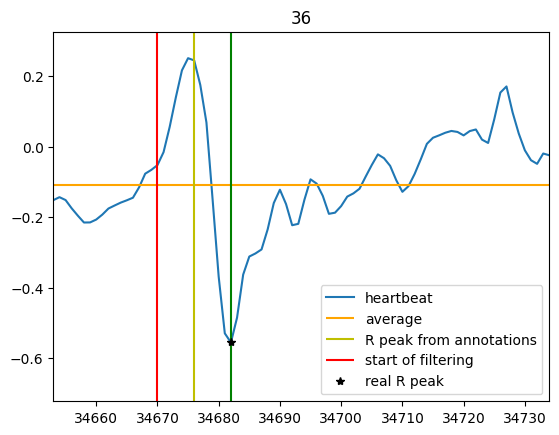

In [69]:
ems = np.where(QRS_start==QRS_end)[0]
em = ems[np.random.randint(len(ems))]
path = str(hb["patient"][em])
data = pd.read_csv("output_files/data"+path+"_filtered.csv")
start = hb['start'][em]
end = hb['end'][em]
R_peak = hb['ann_index'][em]
x_R_peak = hb['x_R_peak'][em]
y_R_peak = hb['y_R_peak'][em]
av = hb['average'][em]
x = np.arange(start,end,1)
y = np.array(data["I"])[start:end]
plt.title(path)
plt.plot(x,y,'-',label='heartbeat')
plt.hlines(av,min(x),max(x),color = 'orange',label='average')
plt.vlines(R_peak,1.3*min(y),1.3*max(y),'y',label='R peak from annotations')
plt.vlines(start_fit[em],1.3*min(y),1.3*max(y),'r',label='start of filtering')
plt.vlines(end_fit[em],1.3*min(y),1.3*max(y),'g')
plt.plot(x_R_peak,y_R_peak,'*k',label='real R peak')
plt.ylim(1.3*min(y),1.3*max(y))
plt.xlim(min(x),max(x))
plt.legend()
plt.show()

#### P Extraction

In [ ]:
t1 = time.time()

x_R_peak = hb['x_R_peak']
start = np.array(hb['start'])
p_start = np.zeros(len(hb), dtype=int)
p_end = np.zeros(len(hb), dtype=int)
x_P_peak = np.zeros(len(hb), dtype=int)
y_P_peak = np.zeros(len(hb))
p_int = np.zeros(len(hb))
p_abs_int = np.zeros(len(hb))

# - the positive integral of the QRS complex
p_pos_int = np.zeros(len(hb))
# - the negative integral of the QRS complex
p_neg_int = np.zeros(len(hb))

start_condition = (QRS_start > start)
good_start = np.where(start_condition)[0]
bad_start = np.where(np.bitwise_not(start_condition))[0]
p_start[good_start] = start[good_start]
p_end[good_start] = QRS_start[good_start]
p_start[bad_start] = start[bad_start]
p_end[bad_start] = start[bad_start]
x_P_peak[bad_start] = start[bad_start]

print(np.all(p_end>=p_start))

# for the non-degenerate cases, we select the interval
for beat in range(len(hb)):
    if path != str(hb["patient"][beat]).zfill(2):
        path = str(hb["patient"][beat]).zfill(2)
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data["I"])
    if (beat in good_start):
        y_p = y[p_start[beat]:p_end[beat]]
        y_P_peak[beat] = np.max(y_p)
        x_P_peak[beat] = np.argmax(y_p) + p_start[beat]
        p_pos_int[beat], p_neg_int[beat] = integral(y_p)
    else:
        y_P_peak[beat] = y[x_P_peak[beat]]
        p_pos_int[beat], p_neg_int[beat] = 0,0


        
print('right order: ',np.all( (start <= p_start) & (p_start <= x_P_peak) & (x_P_peak <= p_end) & (p_end <= QRS_start) ))
t2 = time.time()
print('the feature extraction took: ',t2-t1,'seconds')

In [ ]:
hb['P_start'] = p_start
hb['P_end'] = p_end
hb['P_length'] = p_end - p_start
hb['x_P_peak'] = x_P_peak
hb['y_P_peak'] = y_P_peak
hb['P_pos_int'] = p_pos_int
hb['P_neg_int'] = p_neg_int

hb.head()

### T extraction

In [ ]:
t1 = time.time()

end = np.array(hb['end'])
t_start = np.zeros(len(hb), dtype=int)
t_end = np.zeros(len(hb), dtype=int)
x_T_peak = np.zeros(len(hb), dtype=int)
y_T_peak = np.zeros(len(hb))
t_int = np.zeros(len(hb))
t_abs_int = np.zeros(len(hb))

# - the positive integral of the QRS complex
t_pos_int = np.zeros(len(hb))
# - the negative integral of the QRS complex
t_neg_int = np.zeros(len(hb))

end_condition = (QRS_end < end)
good_end = np.where(end_condition)[0]
bad_end = np.where(np.bitwise_not(end_condition))[0]
t_start[good_end] = QRS_end[good_end]
t_end[good_end] = end[good_end]
t_start[bad_end] = end[bad_end]
t_end[bad_end] = end[bad_end]
x_T_peak[bad_end] = end[bad_end]

print(np.all(t_start>=x_R_peak))

# for the non-degenerate cases, we select the interval
for beat in range(len(hb)):
    if path != str(hb["patient"][beat]).zfill(2):
        path = str(hb["patient"][beat]).zfill(2)
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data["I"])
    if (beat in good_end):
        y_t = y[t_start[beat]:t_end[beat]]
        y_T_peak[beat] = np.max(y_t)
        x_T_peak[beat] = np.argmax(y_t) + t_start[beat]
        t_pos_int[beat], t_neg_int[beat] = integral(y_t)
    else:
        y_T_peak[beat] = y[x_T_peak[beat]]
        t_pos_int[beat], t_neg_int[beat] = 0,0
        

print('right order: ',np.all( (QRS_end <= t_start) & (t_start <= x_T_peak) & (x_T_peak <= t_end) & (t_end <= end) ))
t2 = time.time()
print('the feature extraction took: ',t2-t1,'seconds')

In [ ]:
hb['T_start'] = t_start
hb['T_end'] = t_end
hb['T_length'] = t_end - t_start
hb['x_T_peak'] = x_T_peak
hb['y_T_peak'] = y_T_peak
hb['T_pos_int'] = t_pos_int
hb['T_neg_int'] = t_neg_int

hb.head()

In [ ]:
features_names = list(hb.columns)
no_features = ['patient','idx','ann_symbol']
for nf in no_features:
    features_names.remove(nf)

hand_extracted_features = hb[features_names]
hand_extracted_features = hand_extracted_features.to_numpy()
print((hand_extracted_features[0]))

### Feature from Fast Fourier Transform

In [ ]:
t1 = time.time()
start = np.array(hb["start"])
end = np.array(hb["end"])
R = np.array(hb["ann_index"])

j = np.where(hb['idx']==0)[0]
k = (j -1)[1:]

fixed_start = R - np.min(R[j]-start[j]).astype(int)
fixed_end = R +np.max(end[k]-R[k]).astype(int)
for beat in range(len(hb)):

    if path != str(hb["patient"][beat]).zfill(2):
        path = str(hb["patient"][beat]).zfill(2)
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data["I"])
        
    y_beat = y[fixed_start[beat]:fixed_end[beat]]
    vect_fft, vect_power, vect_all_freq = power_fft(y_beat, timestep)
    temp = np.where((vect_all_freq>down_freq_lim) & (vect_all_freq<up_freq_lim))[0]
    f_keep = vect_power[temp]
    if beat==0:
        f = np.zeros((len(hb),len(f_keep)))
    f[beat,:] = f_keep
    
t2 = time.time()
print("time taken is", round(t2-t1,2) ,"sec")

### Putting everything together as an input for Machine Learning

In [ ]:
ML_input = np.hstack((features,hand_extracted_features, f))

# 5) Machine Learning


# 5A) Preparing the dataset
We consider a binary situation in which 1 corresponds to a normal beat and 0 to abnormal.


In [47]:
X = ML_input
Y = np.array(hb['ann_symbol'])


for i in range(len(Y)):
    if (Y[i] == 'N'):
        Y[i] = 1
    else: Y[i] = 0
        

num = 2072050
np.random.seed(num)

permutation = np.random.permutation(X.shape[0])

X = X[permutation]
Y = Y[permutation]

In [48]:
def splitting_data(m_training, m_test, X, Y):

    X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
    Y_train, Y_test = Y[:m_training].astype('int'), Y[m_training:m_training+m_test:].astype('int')

    labels, freqs = np.unique(Y_train, return_counts=True)
    print("Labels in training dataset: ", labels)
    print("Frequencies in training dataset: ", freqs)
    
    return X_train, Y_train, X_test, Y_test

Setting size of train and test sets:

In [49]:
m_train = 5000
m_test = 5000
X_train, Y_train, X_test, Y_test = splitting_data(m_train, m_test, X, Y)

Labels in training dataset:  [0 1]
Frequencies in training dataset:  [ 691 4309]


In [50]:
sample_weights = compute_sample_weight(class_weight='balanced', y= Y_train)

# xgb_classifier.fit(X, y, sample_weight=sample_weights)

# 5B) GridSearch 


Setting option for GridSearch display:

In [51]:
grid_search = True

### 1) GridSearch for Logistic Regression

In [52]:
# ML_ALGORITHM = 'LogisticRegression'

In [53]:
# if grid_search and (ML_ALGORITHM == 'LogisticRegression'):
    
#     grid = {"C":np.logspace(-3,3,3)}
    
#     logreg = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced')
#     logreg_cv = GridSearchCV(logreg, grid, cv=5, n_jobs=-1)
#     logreg_cv.fit(X_train, Y_train)
    
    

#     print('Best parameters:', logreg_cv.best_params_)
#     print('Accuracy:', logreg_cv.best_score_)

We receive a ConvergenceWarning.

Ways of dealing with it (since already using a 'saga' solver, suggested for large datasets):

- try to increase number of iterations further

- admit that data cannot be fit with LogisticRegression

Best results are with C = 0.001.
Accuracy ~ 74%

### 2) GridSearch for SVM

We impose an rbf kernel (we could add for illustarating purposes also linear and polynomial kernels, but then the code will be maybe too long...)

In [54]:
# ML_ALGORITHM = 'SVM'

In [55]:
# if grid_search and (ML_ALGORITHM == 'SVM'):
    
#     parameters = {'C': [1, 10, 100],'gamma':[0.001, 0.01]}
#     svc_rbf = SVC(kernel='rbf')
#     clf_rbf = GridSearchCV(svc_rbf, parameters, cv=4, n_jobs=-1)
#     clf_rbf.fit(X_train,Y_train)

#     print("Best parameters set found:", clf_rbf.best_params_)

#     print("Score with best parameters:", clf_rbf.best_score_)

#     print("\nAll scores on the grid:", clf_rbf.cv_results_['mean_test_score'])

Best parameters: C = 1, gamma = 0.001. Accuracy ~87%.

### 3) GridSearch for XGBoost

In [56]:
ML_ALGORITHM = 'xgboost'

In [57]:
if grid_search and (ML_ALGORITHM == 'xgboost'):
    model2 = XGBClassifier(objective = 'binary:logistic', #since it's binary classification
                       validate_parameters = True, tree_method='gpu_hist')
    parameters = {'eta': [0.1, 0.2, 0.5],
              'reg_lambda': [0.1, 1, 10], 
              'gamma': [0.01, 0.1, 1]}

    grid_search = GridSearchCV(estimator=model2, param_grid=parameters,
                               scoring = 'roc_auc', n_jobs = 10,cv = 10,verbose=2)
    grid_result = grid_search.fit(X_train, Y_train, sample_weight=sample_weights)
 
    results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                         pd.DataFrame(grid_search.cv_results_["mean_test_score"],
                                      columns=["Accuracy"])],axis=1)

    results_xgb = results.sort_values(by=['Accuracy'], ascending = False)
    results_xgb = results_xgb.reset_index(drop=True)
    best_param_xgboost = results_xgb.head(1)
    
    
    file_path = 'output_files/xgboost_param.csv'

    if not os.path.exists(file_path):
        best_param_xgboost.to_csv('output_files/xgboost_param.csv', index=False)
    
if  (grid_search == False) & (ML_ALGORITHM == 'xgboost'):
    best_param_xgboost =  pd.read_csv('output_files/xgboost_param.csv')  
    
eta = best_param_xgboost.iloc[0,0]
gamma = best_param_xgboost.iloc[0,1]
reg_lambda = best_param_xgboost.iloc[0,2]
print("The best performing combinations of parameters are (from highest to lowest accuracy): ", best_param_xgboost)


Fitting 10 folds for each of 27 candidates, totalling 270 fits
The best performing combinations of parameters are (from highest to lowest accuracy):     eta  gamma  reg_lambda  Accuracy
0  0.2    0.1         1.0  0.997983


In [58]:
best_param_xgboost

,eta,gamma,reg_lambda,Accuracy
0,0.2,0.1,1.0,0.997983


The best parameters for the xgboost are eta = 0.2, gamma = 0.1 and reglambda = 1, for which accurracy is ~ 99.7%.

## 5C) Training

Enlarging set sizes and setting final algorithm:

In [59]:
ML_ALGORITHM = 'xgboost'

In [60]:
m_train = 85000
m_test = 80000
X_train, Y_train, X_test, Y_test = splitting_data(m_train, m_test, X, Y)

Labels in training dataset:  [0 1]
Frequencies in training dataset:  [12208 72792]


In [61]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y= Y_train
)

In [62]:
if ML_ALGORITHM == 'xgboost':
    
    t1 = time.time()
    model_best_xgb = XGBClassifier(objective = 'binary:logistic',
                               eta = eta, gamma = gamma,
                               reg_lambda = reg_lambda, 
                               tree_method='gpu_hist')
    model_best_xgb.fit(X_train, Y_train,  sample_weight=sample_weights)
    Y_pred = model_best_xgb.predict(X_test)
    accuracy = balanced_accuracy_score(Y_test, Y_pred)
    
    print(ML_ALGORITHM, 'gives', round(accuracy,3), 'accuracy')
    t2 = time.time()
    print("the "+ML_ALGORITHM+" ML algorithm took",round((t2-t1),2),'seconds')
    
    
elif ML_ALGORITHM == 'LogisticRegression':
    t1 = time.time()
    
    reg = LogisticRegression(C=1, solver='saga',
                             max_iter=1000, class_weight='balanced').fit(X_train, Y_train)
    Y_pred = reg.predict(X_test)
    accuracy = balanced_accuracy_score(Y_test, Y_pred)
    
    print(ML_ALGORITHM, 'gives', accuracy, 'accuracy')  
    t2 = time.time()
    print("the "+ML_ALGORITHM+" ML algorithm took",round((t2-t1)/60,2),'minutes')
    
    
elif ML_ALGORITHM == 'SVM':
    t1 = time.time()
    
    best_SVM = SVC(kernel='rbf', C=10, gamma = 0.001)
    best_SVM.fit(X_train,Y_train)
    
    Y_pred = best_SVM.predict(X_test)
    accuracy = balanced_accuracy_score(Y_test, Y_pred)
    
    print(ML_ALGORITHM, 'gives', accuracy, 'accuracy')
    t2 = time.time()
    print("the "+ML_ALGORITHM+" ML algorithm took",round((t2-t1)/60,2),'minutes')

xgboost gives 0.988 accuracy
the xgboost ML algorithm took 5.94 seconds


## 5D) Saving pretrained model 

We only save XGBoost model, because it is the best performing model.

In [63]:
file_path = "model100k_more.json"

if not os.path.exists(file_path):
    model_best_xgb.save_model(file_path)
else:
    print("Model already saved in the system previously.")

Model already saved in the system previously.


## 5E) Loading and testing the model

In [64]:
model_xgb_2 = XGBClassifier()
model_xgb_2.load_model("model100k_more.json")

In [65]:
num = 2072053
np.random.seed(num)

permutation = np.random.permutation(X.shape[0])

X = X[permutation]
Y = Y[permutation]

m_train = 80000
m_test = 100000
X_train, Y_train, X_test, Y_test = splitting_data(m_train, m_test, X, Y)
Y_pred = model_xgb_2.predict(X_test)
print('Accuracy:', round(balanced_accuracy_score(Y_test, Y_pred),3))

Labels in training dataset:  [0 1]
Frequencies in training dataset:  [11572 68428]
Accuracy: 0.995


In [66]:
t_end_all = time.time()
print('the entire script run took',round((t_end_all-t_start_all)/60,2),'minutes')

the entire script run took 19.48 minutes


# References
[1] A survey of heart anomaly detection using ambulatory electrocardiogram (ECG). Hongzu  Li and Pierre Boulanger. 2020

[2] ECG signal classification using support vector machine based on wavelet multiresolution analysis. Ayman Rabee and Imad Barhumi. 2012.
